# <b>取得股價資料</b>

In [1]:
import yfinance as yf  # yahoo finance 套件
import pandas as pd  # 結構化資料處理套件
import datetime as dt  # 時間套件

In [2]:
# 輸入股票代號
stock_id = '6223.two'
# stock_id = '2357.tw'
# stock_id = '2317.tw'
# stock_id = 'AAPL'
# stock_id = 'NVDA'

'''今天往前算幾天'''
# 資料結束時間
end = dt.date.today()
# 抓取半年資料（現在-過去180天）
# start = end - dt.timedelta(days=180)

'''抓取特定時間'''
start = dt.datetime(2020, 1, 1)  # 指定的開始日期
end = dt.datetime(2024, 10, 10)    # 指定的結束日期


# 參數1: 股票代號, 參數2: 開始時間, 參數3: 結束時間
stock_data = yf.download(stock_id, start=start, end=end).reset_index()

# 將日期欄位轉為datetime格式
stock_data["Date"] = pd.to_datetime(stock_data["Date"])
# 將日期欄位設為索引
stock_data.set_index("Date", inplace=True)
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2020-01-02  79.800003  79.800003  78.400002  78.599998  66.958794  1173000
2020-01-03  79.300003  79.300003  75.199997  75.300003  64.147545  3127898
2020-01-06  75.000000  75.000000  72.800003  73.099998  62.273376  1932000
2020-01-07  73.400002  74.000000  70.099998  71.500000  60.910351  2273000
2020-01-08  70.800003  75.500000  70.500000  74.099998  63.125278  5642000


In [3]:
# 取得收盤價
close_prices = stock_data[['Close']]

# <b>1. 長短期記憶 (Long Short-Term Memory, LSTM)</b>

## <b>1.1 單步預測</b>
輸入連續 N 天的收盤價，只預測第 N+1 天的收盤價。

### <b>1.1.1 資料前處理</b>


In [4]:
# 資料集拆分
# 訓練資料集佔80%, 測試資料集佔20%
train_size = int(len(close_prices) * 0.8)
train_data = close_prices[:train_size]
test_data = close_prices[train_size:]

In [5]:
# 顯示訓練資料集和測試資料集的大小 (資料筆數, 特徵數)
print('訓練集形狀：', train_data.shape)
print('測試集形狀：', test_data.shape)

訓練集形狀： (926, 1)
測試集形狀： (232, 1)


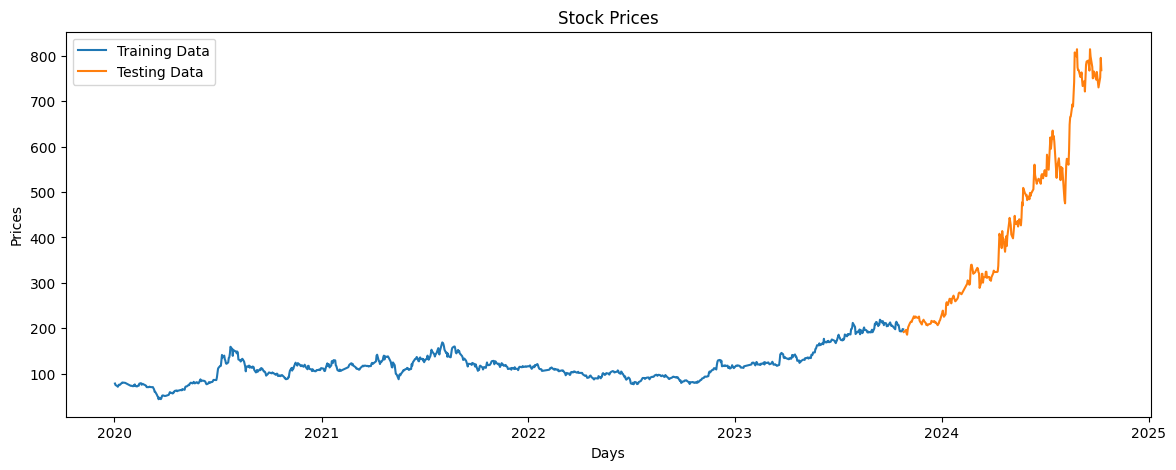

In [6]:
import matplotlib.pyplot as plt  # 畫圖套件

# 顯示訓練集和測試集的收盤價曲線
plt.figure(figsize=(14, 5))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Testing Data')
plt.title('Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [7]:
from sklearn.preprocessing import MinMaxScaler  # 正規化套件

# 正規化數據（僅對訓練集進行 fit）
scaler = MinMaxScaler(feature_range=(0, 1))
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [8]:
import numpy as np  # 數學運算套件

# 設置輸入窗口
window_size = 10

# 構建訓練和測試數據集
def create_dataset(dataset, window_size):
    X, y = [], []
    # 滑動窗口
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(y)


# 訓練集和測試集
X_train, y_train = create_dataset(train_data_scaled, window_size)
X_test, y_test = create_dataset(test_data_scaled, window_size)

# 為了符合 LSTM 的輸入，重塑輸入為 (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
# 輸出訓練和測試數據集的形狀
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(916, 10, 1) (916,) (222, 10, 1) (222,)


### <b>1.1.2 建立 LSTM 模型</b>


In [10]:
from tensorflow.keras.models import Sequential  # 模型容器
from tensorflow.keras.layers import (
    Input,  # 輸入層
    LSTM,  # LSTM 層
    Dense,  # 全連接層
    Dropout  # Dropout 層
)

lstm_model = Sequential(name='one-step_prediction_lstm_model')  # 創建模型
lstm_model.add(Input(shape=(window_size, 1), name='Input'))  # 輸入層 (窗口大小，特徵數)
lstm_model.add(LSTM(64, name='LSTM'))  # LSTM 層 (64 個神經元)
lstm_model.add(Dense(64, name='Dense_1'))  # 全連接層 (64 個神經元)
lstm_model.add(Dropout(0.2, name='Dropout_1'))  # Dropout 層 (0.2) 隨機關閉 20% 神經元
lstm_model.add(Dense(32, name='Dense_2'))  # 全連接層 (32 個神經元)
lstm_model.add(Dropout(0.2, name='Dropout_2'))  # Dropout 層 (0.2) 隨機關閉 20% 神經元
lstm_model.add(Dense(1, name='Output'))  # 輸出層 (1 個神經元)
lstm_model.compile(optimizer='adam', loss='mse')  # 編譯模型
lstm_model.summary()  # 顯示模型結構

Model: "one-step_prediction_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,169 (90.50 KB)

 Trainable params: 23,169 (90.50 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 訓練模型
hist = lstm_model.fit(
    X_train,  # 特徵
    y_train,  # 標籤
    epochs=50,  # 訓練次數
    batch_size=32,  # 批次大小
    validation_split=0.2,  # 驗證集比例
    verbose=1  # 顯示訓練過程 (0: 不顯示, 1: 顯示進度條, 2: 顯示每個 epoch)
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0021 - val_loss: 0.0031
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0017 - val_loss: 7.9566e-04
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_loss: 8.2589e-04
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 

### <b>1.1.3 結果評估</b>


In [13]:
# 評估測試集
mse = lstm_model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0214     
Mean Squared Error: 0.0546109564602375


In [14]:
# 預測股價
y_pred = lstm_model.predict(X_test)
# 反正規化預測值 (0~1 -> 實際值)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
# 預測值轉為 DataFrame 格式
test_predict = pd.DataFrame(
    y_pred, columns=['Predicted'], index=test_data[window_size:].index)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


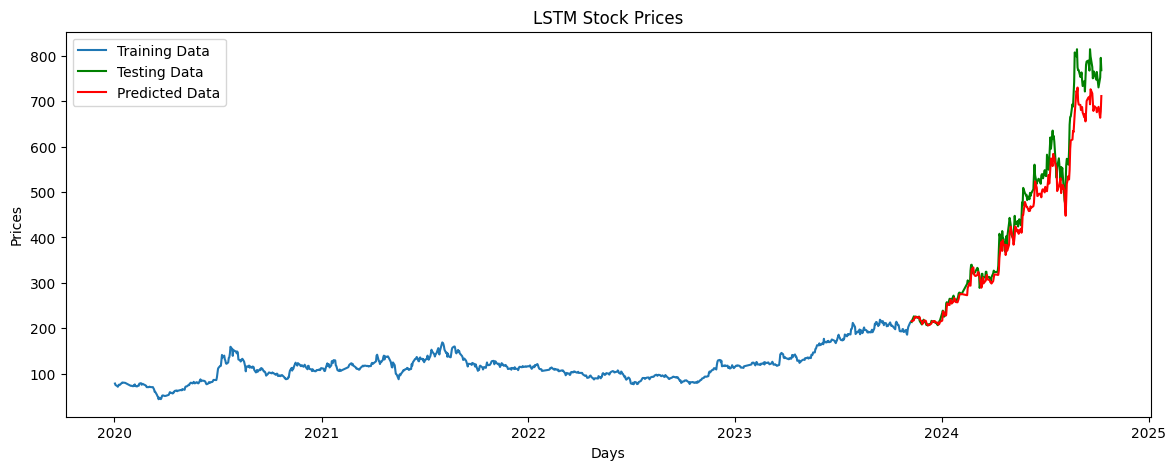

In [15]:
# 繪製整個資料集
plt.figure(figsize=(14, 5))
plt.plot(close_prices[:train_size + window_size],
         label='Training Data')  # 訓練集部分
plt.plot(close_prices[train_size + window_size:],
         label='Testing Data', color='green')  # 測試集部分
plt.plot(test_predict, label='Predicted Data', color='red')  # 預測部分
plt.title('LSTM Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

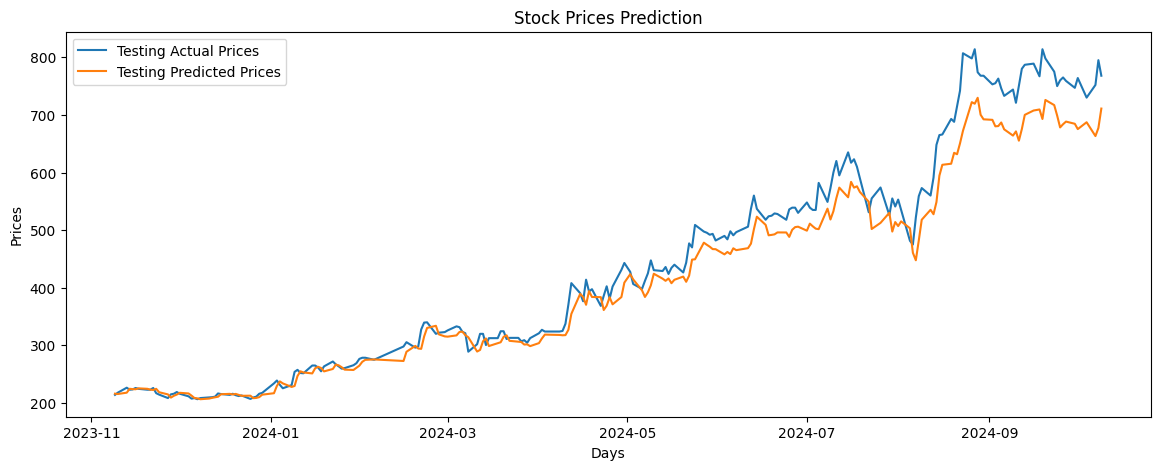

In [16]:
# 繪製測試集部分
plt.figure(figsize=(14, 5))
plt.plot(close_prices[train_size + window_size:],
         label='Testing Actual Prices')
plt.plot(test_predict, label='Testing Predicted Prices')
plt.title('Stock Prices Prediction')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

---

## <b>1.2 多步預測</b>
輸入連續 N 天的收盤價，預測接下來 M 天的收盤價。

### <b>1.2.2 資料前處理</b>

In [17]:
import numpy as np  # 數學運算套件

# 設置輸入窗口
window_size = 20  # 輸入20日股價
# 預測步數
n_outputs = 20  # 預測20日股價

# 構建訓練和測試數據集，加入預測步數
def create_dataset(dataset, window_size, n_outputs):
    X, y = [], []
    # 滑動窗口
    for i in range(len(dataset) - window_size - n_outputs + 1):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size:i + window_size + n_outputs, 0])
    return np.array(X), np.array(y)

# 訓練集和測試集
X_train, y_train = create_dataset(train_data_scaled, window_size, n_outputs)
X_test, y_test = create_dataset(test_data_scaled, window_size, n_outputs)

# 為了符合 LSTM 的輸入，重塑輸入為 (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [19]:
# 輸出訓練和測試數據集的形狀
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(887, 20, 1) (887, 20) (193, 20, 1) (193, 20)


### <b>2.2 建立 LSTM 模型</b>

In [20]:
from tensorflow.keras.models import Sequential  # 模型容器
from tensorflow.keras.layers import (
    Input,  # 輸入層
    LSTM,  # LSTM 層
    Dense,  # 全連接層
    Dropout  # Dropout 層
)

lstm_model = Sequential(name='multi-step_prediction_lstm_model')  # 創建模型
lstm_model.add(Input(shape=(window_size, 1), name='Input'))  # 輸入層 (窗口大小，特徵數)
lstm_model.add(LSTM(64, name='LSTM'))  # LSTM 層 (64 個神經元)
lstm_model.add(Dense(64, name='Dense_1'))  # 全連接層 (64 個神經元)
lstm_model.add(Dropout(0.2, name='Dropout_1'))  # Dropout 層 (0.2) 隨機關閉 20% 神經元
lstm_model.add(Dense(32, name='Dense_2'))  # 全連接層 (32 個神經元)
lstm_model.add(Dropout(0.2, name='Dropout_2'))  # Dropout 層 (0.2) 隨機關閉 20% 神經元
lstm_model.add(Dense(n_outputs, name='Output'))  # 輸出層 (n_outputs 個神經元)
lstm_model.compile(optimizer='adam', loss='mse')  # 編譯模型
lstm_model.summary()  # 顯示模型結構

Model: "multi-step_prediction_lstm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,796 (92.95 KB)

 Trainable params: 23,796 (92.95 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# 訓練模型
hist = lstm_model.fit(
    X_train,  # 特徵
    y_train,  # 標籤
    epochs=50,  # 訓練次數
    batch_size=32,  # 批次大小
    validation_split=0.2,  # 驗證集比例
    verbose=1  # 顯示訓練過程 (0: 不顯示, 1: 顯示進度條, 2: 顯示每個 epoch)
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0174
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0150
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0129
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0195
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0139
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0069 - val_loss: 0.0202
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0114
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0068 - val_loss: 0.0243
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0062 - val_loss: 0.0172
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0066 - val_loss: 0.0164
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0063 - val_loss: 0.0131
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0064 - val_lo

### <b>2.3 結果評估</b>

In [23]:
# 評估測試集
mse = lstm_model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7999 
Mean Squared Error: 1.4453227519989014


In [24]:
# 預測股價
y_pred = lstm_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
test_true = scaler.inverse_transform(y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [25]:
len(test_true[:, 0]), len(y_pred[:, 0])

(193, 193)

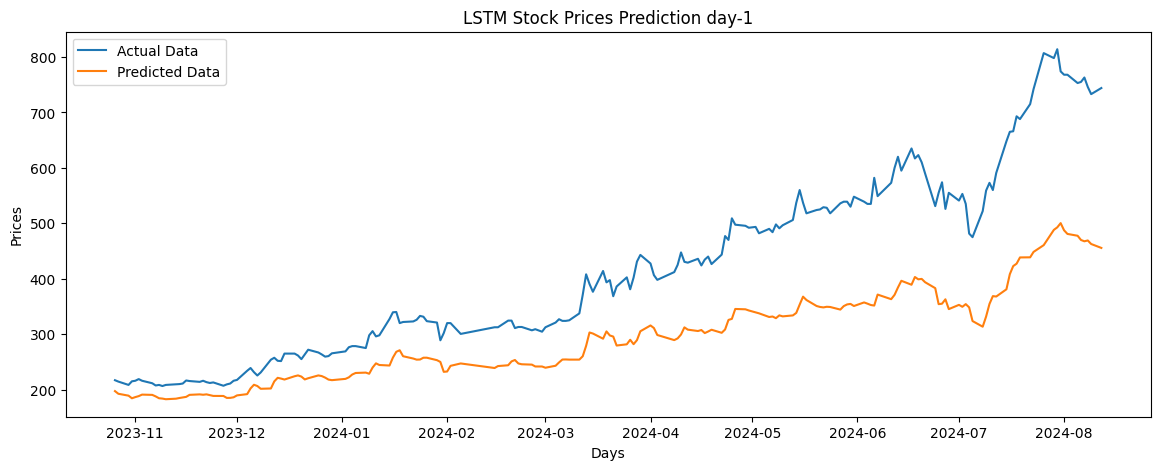

Day 1 MSE: 21440.444162870575



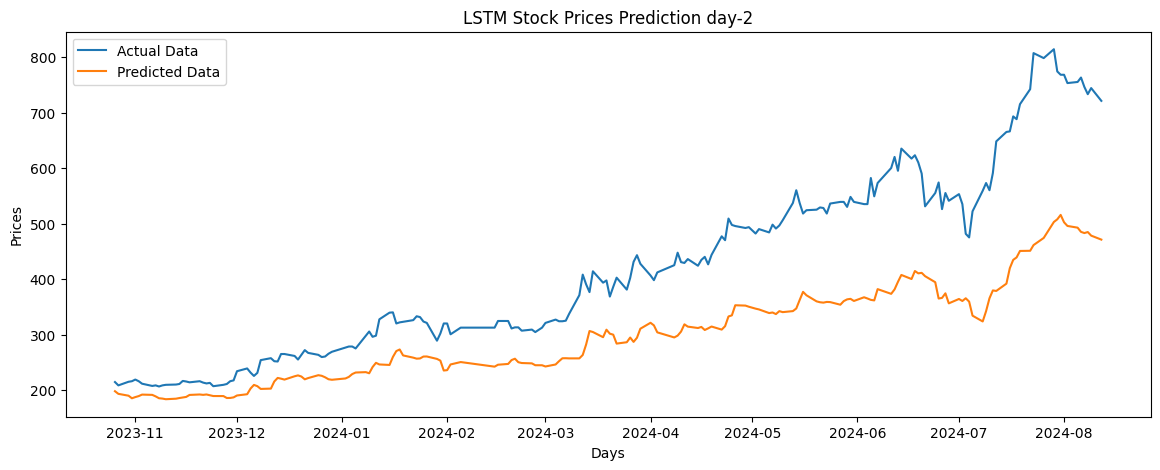

Day 2 MSE: 20290.54862044982



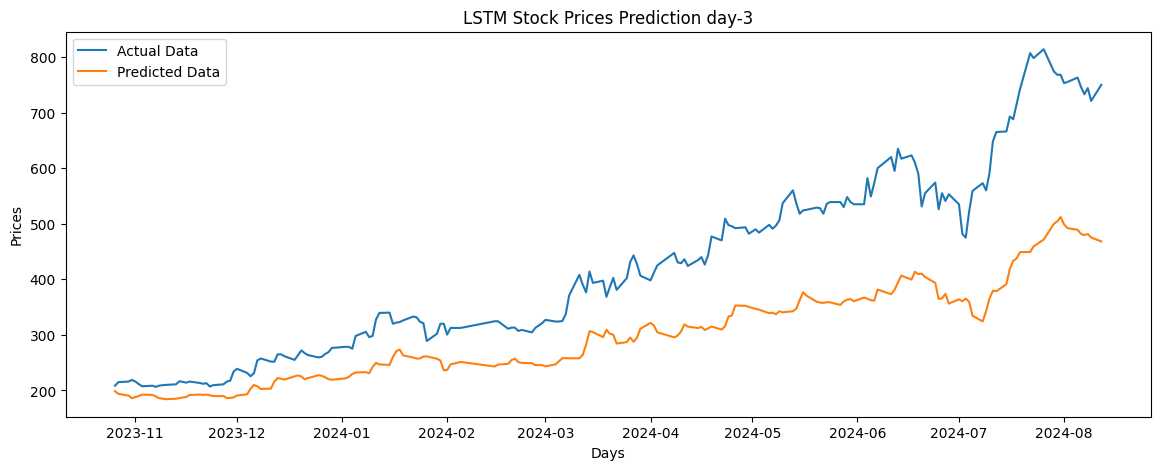

Day 3 MSE: 21354.441777497515



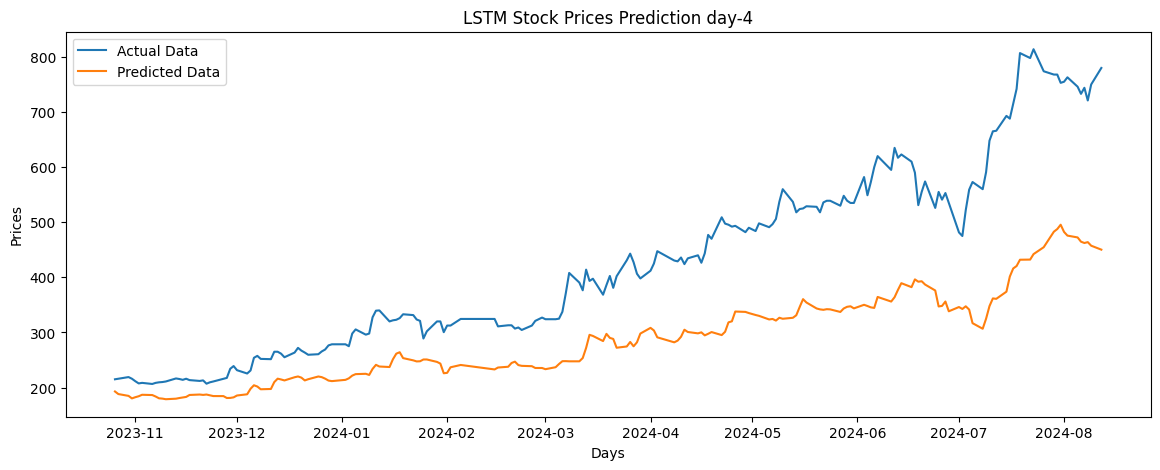

Day 4 MSE: 26204.52718008789



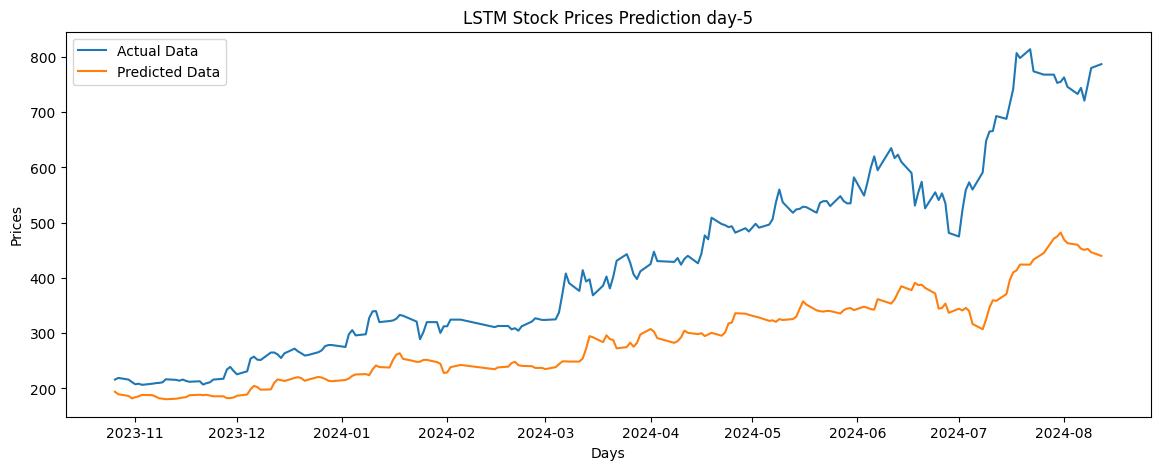

Day 5 MSE: 28194.812737451026



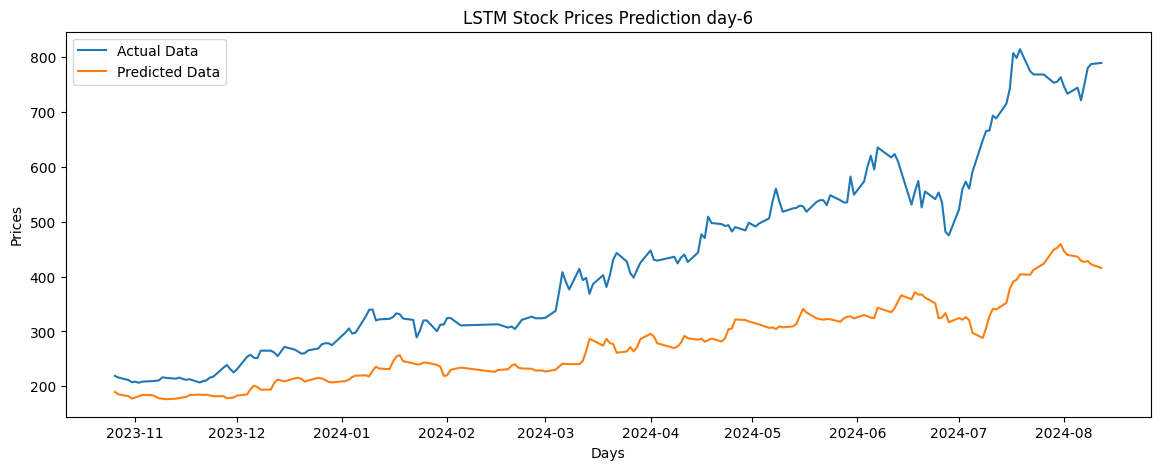

Day 6 MSE: 34064.695926321394



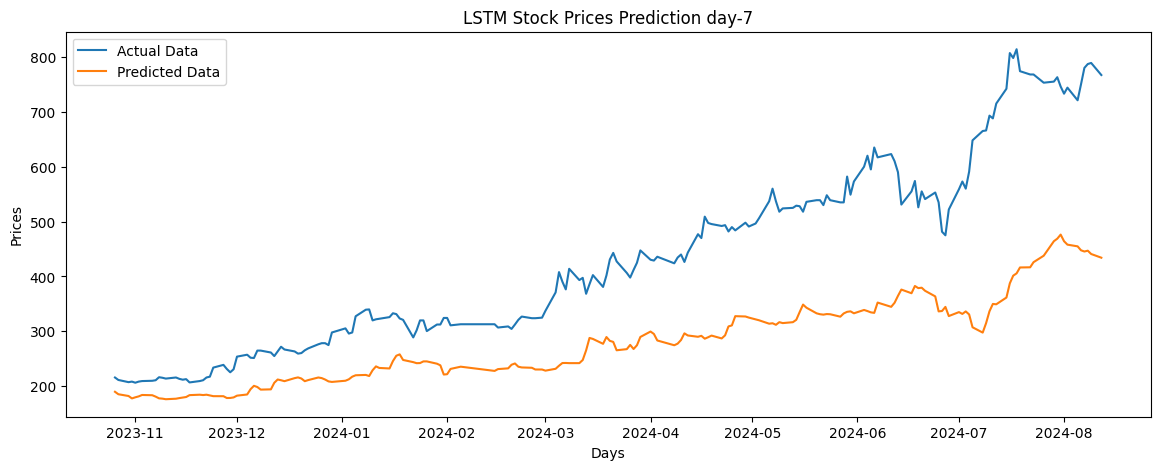

Day 7 MSE: 32829.39136772401



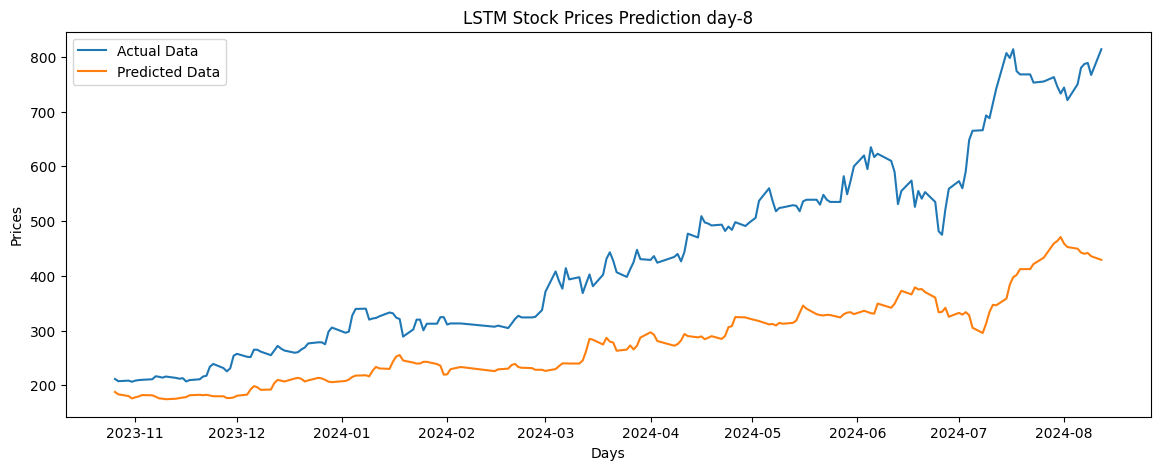

Day 8 MSE: 35177.26498350218



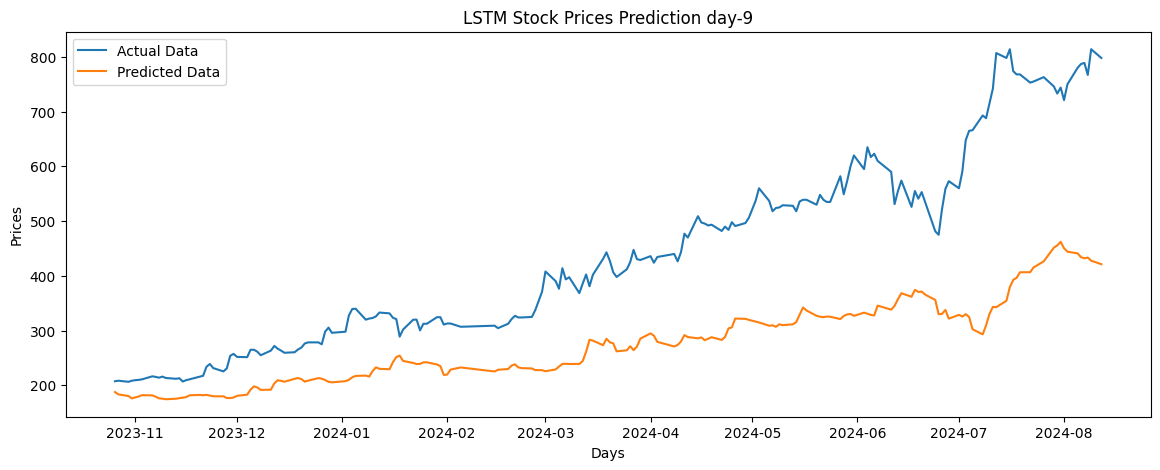

Day 9 MSE: 37526.78349184506



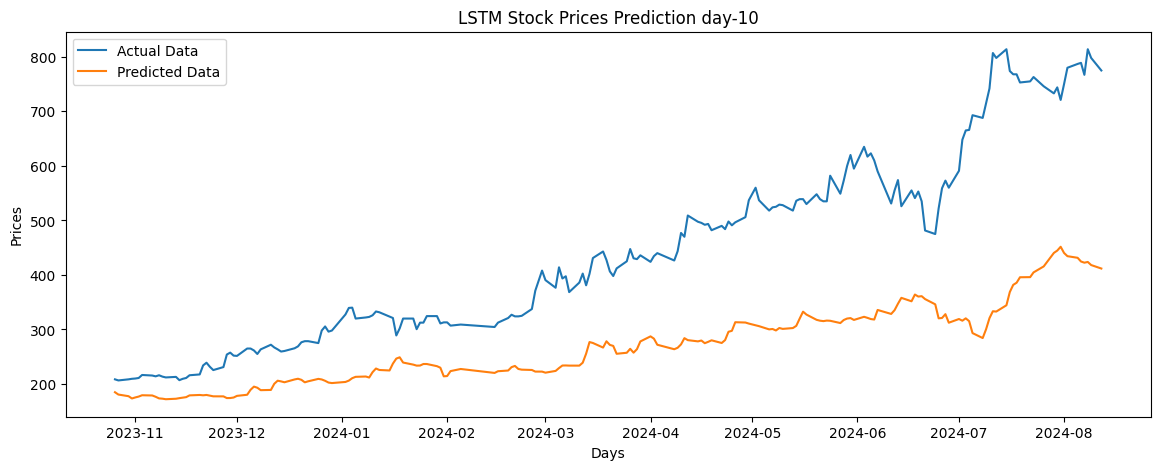

Day 10 MSE: 41579.47276202244



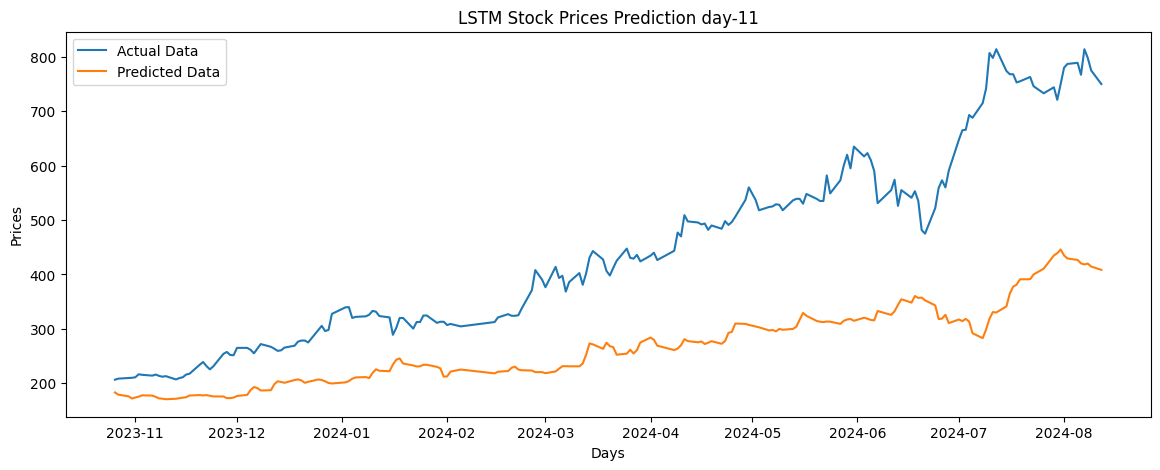

Day 11 MSE: 43861.68241230571



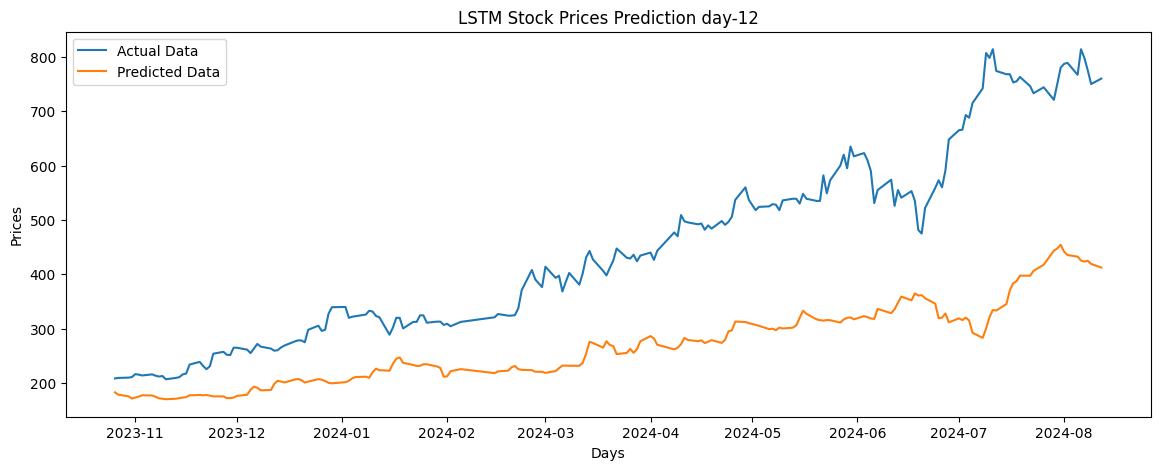

Day 12 MSE: 44205.51882491721



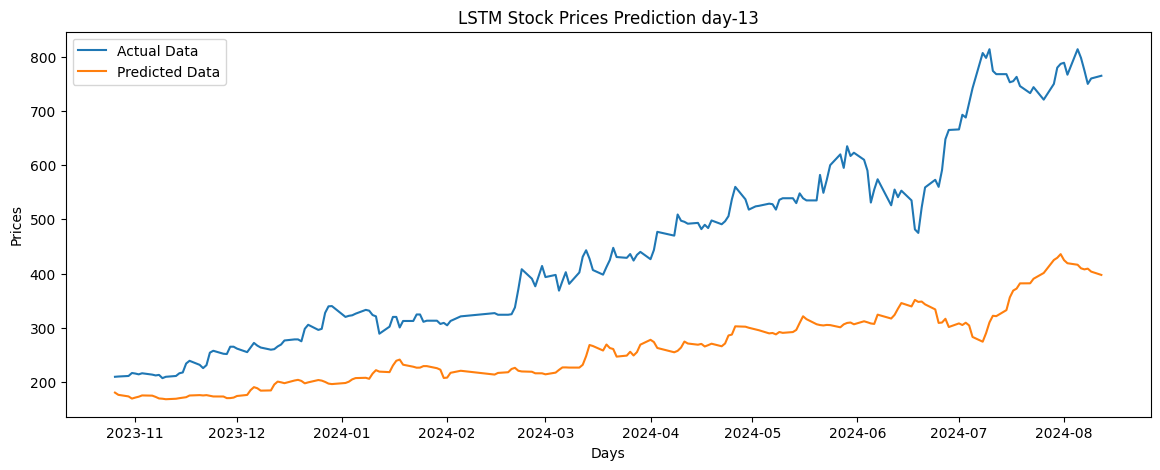

Day 13 MSE: 49127.65119044608



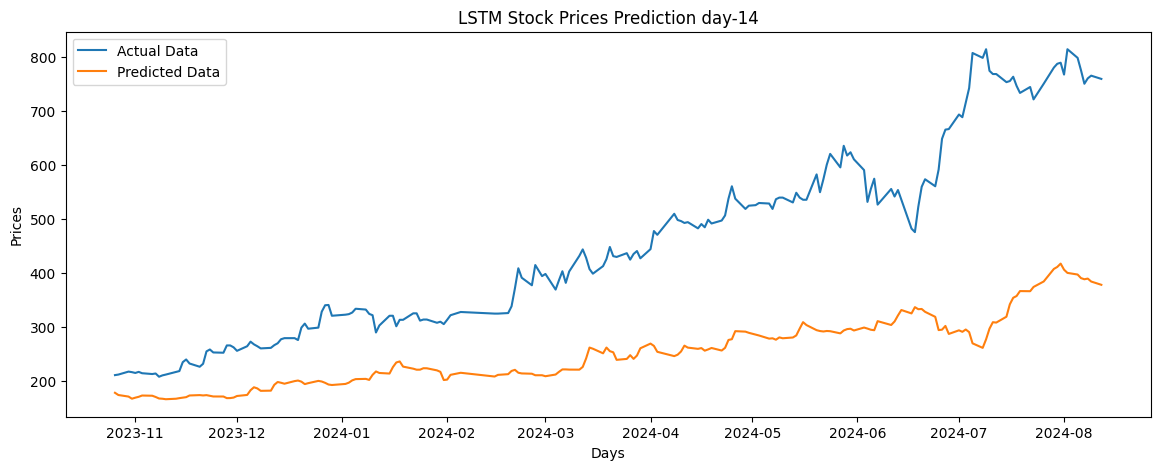

Day 14 MSE: 55061.55413982062



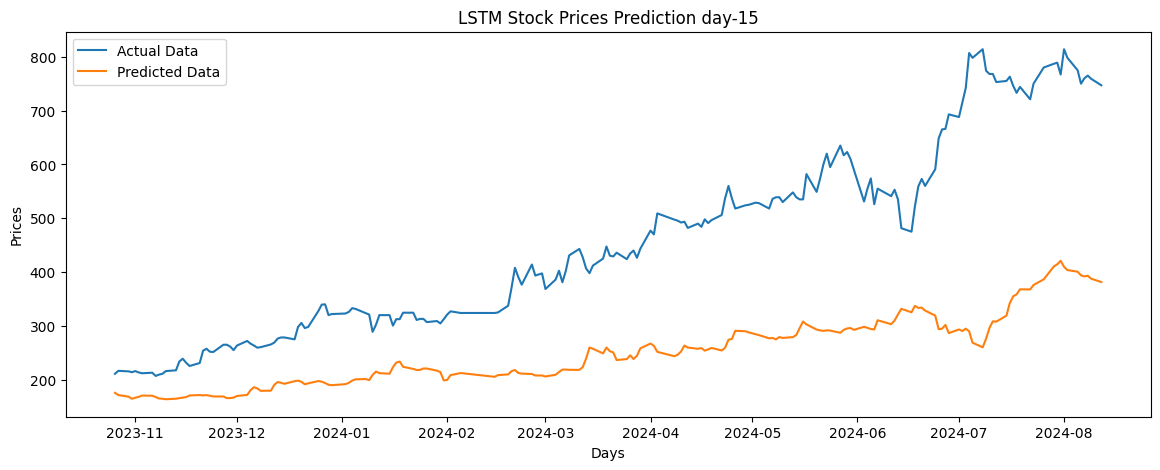

Day 15 MSE: 56324.024804491884



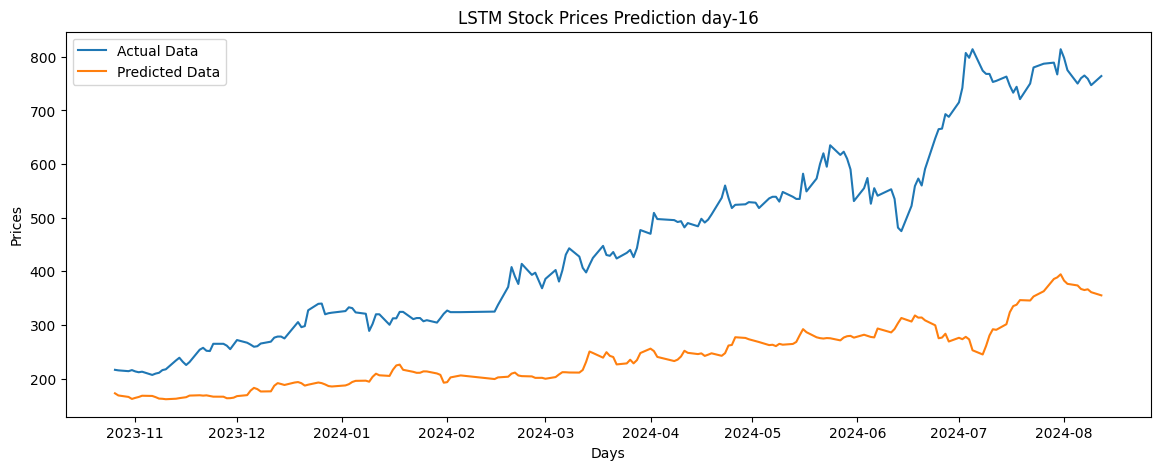

Day 16 MSE: 63662.72002774733



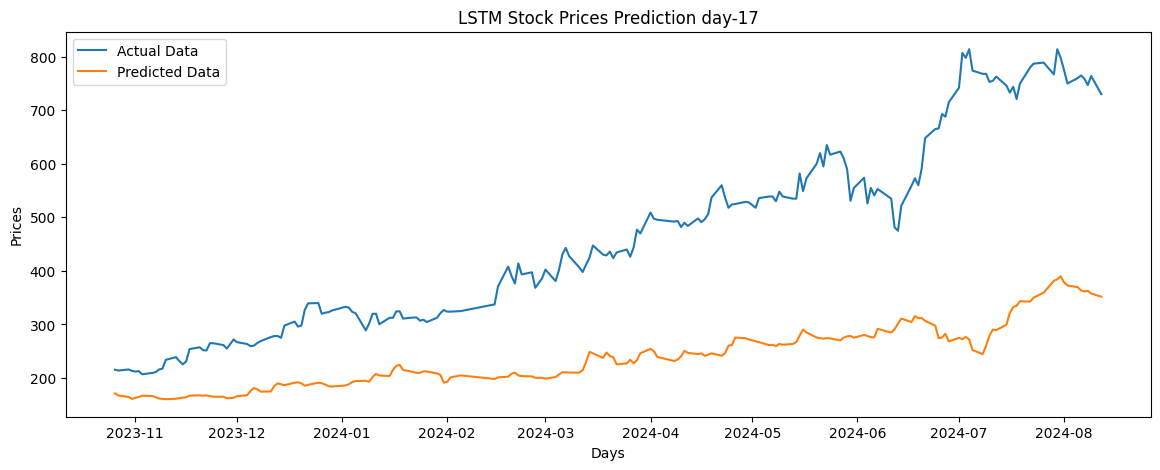

Day 17 MSE: 65643.3180952968



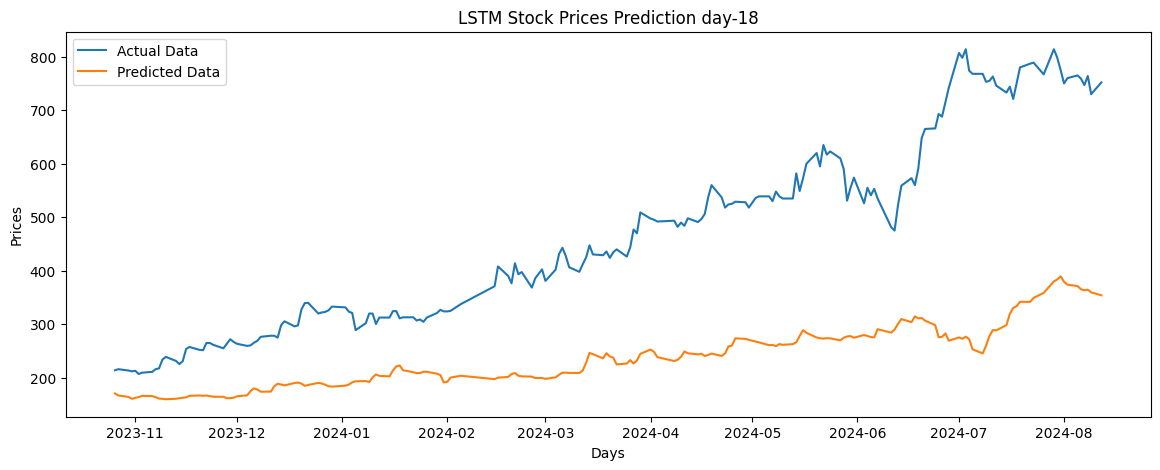

Day 18 MSE: 67244.13727117029



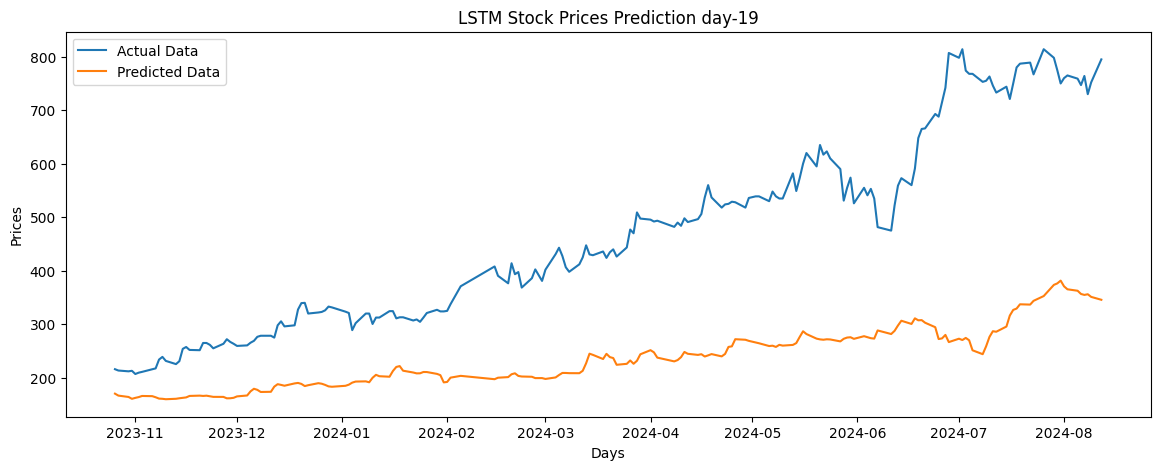

Day 19 MSE: 69853.24339225618



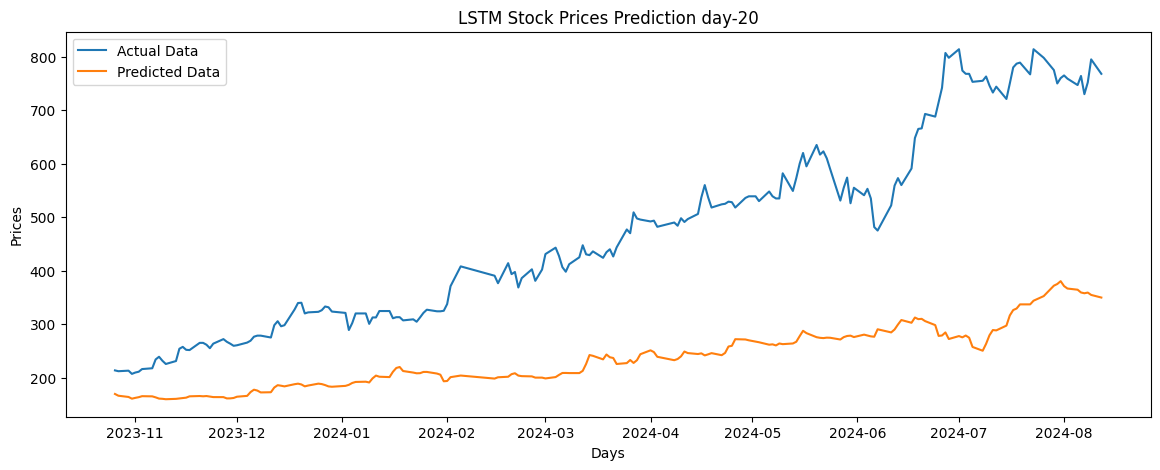

Day 20 MSE: 70602.5147325105



In [26]:
from sklearn.metrics import mean_squared_error  # 均方誤差

for i in range(n_outputs):
    plt.figure(figsize=(14, 5))
    test_true_df = pd.DataFrame(
        test_true[:, i], columns=['Actual'], index=test_data.index[:len(test_true)])
    test_predict_df = pd.DataFrame(
        y_pred[:, i], columns=['Predicted'], index=test_data.index[:len(y_pred)])
    plt.plot(test_true_df, label='Actual Data')  # 畫出實際數據
    plt.plot(test_predict_df, label='Predicted Data')  # 畫出預測數據
    plt.title(f'LSTM Stock Prices Prediction day-{i + 1}')
    plt.xlabel('Days')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()
    mse = mean_squared_error(test_true[:, i], y_pred[:, i])
    print(f'Day {i + 1} MSE:', mse)
    print()

---

# <b>2. Transformer</b>

## <b>2.1 單步預測</b>
輸入連續 N 天的收盤價，只預測第 N+1 天的收盤價。

### <b>2.1.1 資料前處理</b>


In [27]:
# 設置輸入窗口
window_size = 10

# 構建訓練和測試數據集
def create_dataset(dataset, window_size):
    X, y = [], []
    # 滑動窗口
    for i in range(len(dataset) - window_size):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size, 0])
    return np.array(X), np.array(y)


# 訓練集和測試集
X_train, y_train = create_dataset(train_data_scaled, window_size)
X_test, y_test = create_dataset(test_data_scaled, window_size)

# 為了符合 LSTM 的輸入，重塑輸入為 (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [28]:
# 輸出訓練和測試數據集的形狀
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(916, 10, 1) (916,) (222, 10, 1) (222,)


### <b>2.1.2 建立 Transformer 模型</b>

![transformer architecture](https://www.tensorflow.org/images/tutorials/transformer/transformer.png)

In [29]:
import tensorflow as tf  # TensorFlow 套件
from tensorflow.keras import layers  # 從 Keras 中引入 layers 以方便建立模型層

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
    '''
    單一的 Transformer 編碼器魔塊。

    參數:
    - inputs: 輸入的張量 (Tensor)。
    - head_size: 每個注意力頭的維度大小。
    - num_heads: 注意力頭的數量。
    - ff_dim: 前饋神經網路的維度大小。
    - dropout: Dropout 的比率，用於防止過擬合。
    - epsilon: 用於層正規化的微小數值，避免除以 0 的情況。
    - attention_axes: 指定多頭注意力機制的軸向（例如時間軸）。
    - kernel_size: 1D 卷積的卷積核大小。

    回傳:
    - 編碼器塊處理後的張量。
    '''
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)  # 正規化層
    # 多頭注意力機制
    x = layers.MultiHeadAttention(
        key_dim=head_size,  # 注意力頭的維度大小
        num_heads=num_heads,  # 注意力頭的數量
        dropout=dropout,  # Dropout 的比率
        attention_axes=attention_axes
    )(x, x)  # 自注意力機制，q, k, v 均來自於 x 本身
    x = layers.Dropout(dropout)(x)  # Dropout 以防止過擬合
    # 殘差連接 (Residual connection) 將注意力輸出與原始輸入相加
    res = x + inputs

    # Feed Forward 部分
    x = layers.LayerNormalization(epsilon=epsilon)(res)  # 正規化層
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation='relu')(x)  # 卷積層 (第一層)，ReLU 激活函數
    x = layers.Dropout(dropout)(x)  # Dropout 以防止過擬合
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)  # 卷積層 (第二層)，沒有激活函數
    return x + res  # 殘差連接 (Residual connection) 將注意力輸出與原始輸入相加

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
    '''
    建立最終的 Transformer 模型，由多個 Transformer 編碼器塊組成。

    參數:
    - head_size: 每個注意力頭的維度大小。
    - num_heads: 注意力頭的數量。
    - ff_dim: 前饋神經網路的維度大小。
    - num_trans_blocks: Transformer 編碼器塊的數量。
    - mlp_units: MLP 的全連接層單元數列表。
    - dropout: 編碼器塊內的 Dropout 比率，用於防止過擬合。
    - mlp_dropout: MLP 層的 Dropout 比率。
    - attention_axes: 指定多頭注意力機制的軸向（例如時間軸）。
    - epsilon: 用於層正規化的微小數值，避免除以 0 的情況。
    - kernel_size: 1D 卷積的卷積核大小。

    回傳:
    - 最終的 Transformer 模型。

    '''
    # 定義輸入張量的形狀
    window_size, n_outputs, n_features = 10, 1, 1  # 這裡的數值為範例，可根據資料自行調整

    inputs = tf.keras.Input(shape=(window_size, n_features), name='Input')  # 建立輸入層
    x = inputs  # 初始化輸入

    # 產生多個 Transformer 編碼器塊
    for _ in range(num_trans_blocks):
        x = transformer_encoder(
            x,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            attention_axes=attention_axes,
            kernel_size=kernel_size,
            epsilon=epsilon
        )

    # 全局平均池化層，用於壓縮時間步維度
    x = layers.GlobalAveragePooling1D(data_format='channels_first')(x)

    # 多層感知器 (MLP)
    for dim in mlp_units:
        x = layers.Dense(dim, activation='relu')(x)  # 全連接層，ReLU 激活函數
        x = layers.Dropout(mlp_dropout)(x)  # Dropout 以防止過擬合

    # 最終輸出層
    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs, name='one-step_prediction_transformer_encoder_model')  # 建立模型並返回模型

In [30]:
# 建立 Transfomer 模型
transformer_model = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
transformer_model.compile(optimizer='adam', loss='mse') # 編譯模型
transformer_model.summary()

Model: "one-step_prediction_transformer_encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 10, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 1)     │          2 │ Input[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 1)     │          0 │ dropout_1[0][0],  │
│                     │                   │            │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 2)     │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 1)     │          3 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 1)     │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10, 1)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 1)     │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10, 2)     │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 10, 1)     │          3 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 1)     │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 1)     │          2 │ add_3[0][0]     

 Total params: 17,457 (68.19 KB)

 Trainable params: 17,457 (68.19 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# 訓練模型
hist = transformer_model.fit(
    X_train,  # 特徵
    y_train,  # 標籤
    epochs=30,  # 訓練次數
    batch_size=32,  # 批次大小
    validation_split=0.2,  # 驗證集比例
    verbose=1  # 顯示訓練過程 (0: 不顯示, 1: 顯示進度條, 2: 顯示每個 epoch)
)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6735e-04 - val_loss: 0.0010
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.1533e-04 - val_loss: 0.0023
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.1961e-04 - val_loss: 0.0016
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.6258e-04 - val_loss: 6.6727e-04
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.8318e-04 - val_loss: 0.0024
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.5162e-04 - val_loss: 0.0011
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.1690e-04 - val_loss: 0.0012
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7182e-04 - val_loss: 9.7376e-04
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.2913e-04 - val_loss: 0.0011
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7964e-04 - val_loss: 0.0022
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.6472e-04 - val_loss: 6.9140e-04
Epoch 1

### <b>2.1.3 結果評估</b>


In [34]:
mse = transformer_model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0381 
Mean Squared Error: 0.08020637929439545


In [35]:
# 預測股價
y_pred = transformer_model.predict(X_test)
# 反正規化預測值 (0~1 -> 實際值)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
# 預測值轉為 DataFrame 格式
test_predict = pd.DataFrame(
    y_pred, columns=['Predicted'], index=test_data[window_size:].index)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step


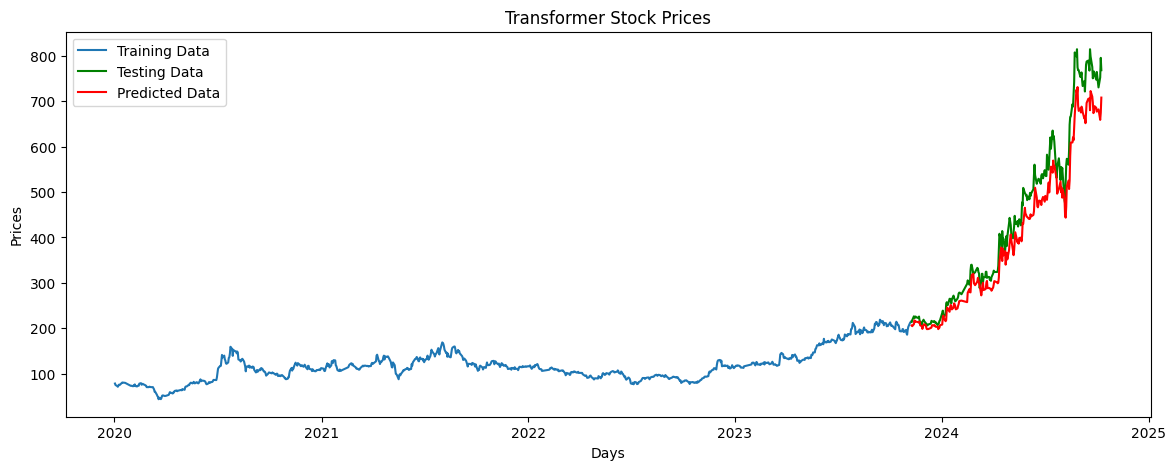

In [36]:
# 繪製整個資料集
plt.figure(figsize=(14, 5))
plt.plot(close_prices[:train_size + window_size],
         label='Training Data')  # 訓練集部分
plt.plot(close_prices[train_size + window_size:],
         label='Testing Data', color='green')  # 測試集部分
plt.plot(test_predict, label='Predicted Data', color='red')  # 預測部分
plt.title('Transformer Stock Prices')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.legend()
plt.show()

## <b>2.2 多步預測</b>
輸入連續 N 天的收盤價，預測接下來 M 天的收盤價。

### <b>2.2.1 資料前處理</b>


In [37]:
import numpy as np  # 數學運算套件

# 設置輸入窗口
window_size = 20  # 輸入20日股價
# 預測步數
n_outputs = 20  # 預測20日股價

# 構建訓練和測試數據集，加入預測步數
def create_dataset(dataset, window_size, n_outputs):
    X, y = [], []
    # 滑動窗口
    for i in range(len(dataset) - window_size - n_outputs + 1):
        X.append(dataset[i:i + window_size, 0])
        y.append(dataset[i + window_size:i + window_size + n_outputs, 0])
    return np.array(X), np.array(y)

# 訓練集和測試集
X_train, y_train = create_dataset(train_data_scaled, window_size, n_outputs)
X_test, y_test = create_dataset(test_data_scaled, window_size, n_outputs)

# 為了符合 LSTM 的輸入，重塑輸入為 (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [38]:
# 輸出訓練和測試數據集的形狀
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(887, 20, 1) (887, 20) (193, 20, 1) (193, 20)


### <b>2.2.2 建立 Transformer 模型</b>

![transformer architecture](https://www.tensorflow.org/images/tutorials/transformer/transformer.png)

In [39]:
import tensorflow as tf  # TensorFlow 套件
from tensorflow.keras import layers  # 從 Keras 中引入 layers 以方便建立模型層

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0, epsilon=1e-6, attention_axes=None, kernel_size=1):
    '''
    單一的 Transformer 編碼器魔塊。

    參數:
    - inputs: 輸入的張量 (Tensor)。
    - head_size: 每個注意力頭的維度大小。
    - num_heads: 注意力頭的數量。
    - ff_dim: 前饋神經網路的維度大小。
    - dropout: Dropout 的比率，用於防止過擬合。
    - epsilon: 用於層正規化的微小數值，避免除以 0 的情況。
    - attention_axes: 指定多頭注意力機制的軸向（例如時間軸）。
    - kernel_size: 1D 卷積的卷積核大小。

    回傳:
    - 編碼器塊處理後的張量。
    '''
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)  # 正規化層
    # 多頭注意力機制
    x = layers.MultiHeadAttention(
        key_dim=head_size,  # 注意力頭的維度大小
        num_heads=num_heads,  # 注意力頭的數量
        dropout=dropout,  # Dropout 的比率
        attention_axes=attention_axes
    )(x, x)  # 自注意力機制，q, k, v 均來自於 x 本身
    x = layers.Dropout(dropout)(x)  # Dropout 以防止過擬合
    # 殘差連接 (Residual connection) 將注意力輸出與原始輸入相加
    res = x + inputs

    # Feed Forward 部分
    x = layers.LayerNormalization(epsilon=epsilon)(res)  # 正規化層
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size, activation='relu')(x)  # 卷積層 (第一層)，ReLU 激活函數
    x = layers.Dropout(dropout)(x)  # Dropout 以防止過擬合
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)  # 卷積層 (第二層)，沒有激活函數
    return x + res  # 殘差連接 (Residual connection) 將注意力輸出與原始輸入相加

def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0, mlp_dropout=0, attention_axes=None, epsilon=1e-6, kernel_size=1):
    '''
    建立最終的 Transformer 模型，由多個 Transformer 編碼器塊組成。

    參數:
    - head_size: 每個注意力頭的維度大小。
    - num_heads: 注意力頭的數量。
    - ff_dim: 前饋神經網路的維度大小。
    - num_trans_blocks: Transformer 編碼器塊的數量。
    - mlp_units: MLP 的全連接層單元數列表。
    - dropout: 編碼器塊內的 Dropout 比率，用於防止過擬合。
    - mlp_dropout: MLP 層的 Dropout 比率。
    - attention_axes: 指定多頭注意力機制的軸向（例如時間軸）。
    - epsilon: 用於層正規化的微小數值，避免除以 0 的情況。
    - kernel_size: 1D 卷積的卷積核大小。

    回傳:
    - 最終的 Transformer 模型。

    '''
    # 定義輸入張量的形狀
    window_size, n_outputs, n_features = 20, 20, 1  # 這裡的數值為範例，可根據資料自行調整

    inputs = tf.keras.Input(shape=(window_size, n_features), name='Input')  # 建立輸入層
    x = inputs  # 初始化輸入

    # 產生多個 Transformer 編碼器塊
    for _ in range(num_trans_blocks):
        x = transformer_encoder(
            x,
            head_size=head_size,
            num_heads=num_heads,
            ff_dim=ff_dim,
            dropout=dropout,
            attention_axes=attention_axes,
            kernel_size=kernel_size,
            epsilon=epsilon
        )

    # 全局平均池化層，用於壓縮時間步維度
    x = layers.GlobalAveragePooling1D(data_format='channels_first')(x)

    # 多層感知器 (MLP)
    for dim in mlp_units:
        x = layers.Dense(dim, activation='relu')(x)  # 全連接層，ReLU 激活函數
        x = layers.Dropout(mlp_dropout)(x)  # Dropout 以防止過擬合

    # 最終輸出層
    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs, name='multi-step_prediction_transformer_encoder_model')  # 建立模型並返回模型

In [40]:
# 建立 Transfomer 模型
transformer_model = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
transformer_model.compile(optimizer='adam', loss='mse') # 編譯模型
transformer_model.summary()

Model: "multi-step_prediction_transformer_encoder_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 20, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ Input[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 20, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 20, 1)     │          0 │ dropout_14[0][0], │
│                     │                   │            │ Input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 20, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 20, 2)     │          0 │ conv1d_8[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 20, 1)     │          3 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 20, 1)     │          0 │ conv1d_9[0][0],   │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 20, 1)     │      3,585 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 20, 1)     │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 20, 1)     │          0 │ dropout_17[0][0], │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 20, 1)     │          2 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 20, 2)     │          4 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 20, 2)     │          0 │ conv1d_10[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 20, 1)     │          3 │ dropout_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 24,900 (97.27 KB)

 Trainable params: 24,900 (97.27 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# 訓練模型
hist = transformer_model.fit(
    X_train,  # 特徵
    y_train,  # 標籤
    epochs=25,  # 訓練次數
    batch_size=32,  # 批次大小
    validation_split=0.2,  # 驗證集比例
    verbose=1  # 顯示訓練過程 (0: 不顯示, 1: 顯示進度條, 2: 顯示每個 epoch)
)

Epoch 1/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 0.0873 - val_loss: 0.0382
Epoch 2/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0137 - val_loss: 0.0186
Epoch 3/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0114 - val_loss: 0.0134
Epoch 4/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0088 - val_loss: 0.0198
Epoch 5/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0082 - val_loss: 0.0096
Epoch 6/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0076 - val_loss: 0.0181
Epoch 7/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0073 - val_loss: 0.0127
Epoch 8/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0067 - val_loss: 0.0134
Epoch 9/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0068 - val_loss: 0.0106
Epoch 10/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0062 - val_loss: 0.0157
Epoch 11/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0062 - val_loss: 0.0150
Epoch 12/25
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0

### <b>2.2.3 結果評估</b>


In [42]:
# 評估測試集
mse = transformer_model.evaluate(X_test, y_test)
print('Mean Squared Error:', mse)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2754 
Mean Squared Error: 0.47003042697906494


In [43]:
# 預測股價
y_pred = transformer_model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
test_true = scaler.inverse_transform(y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


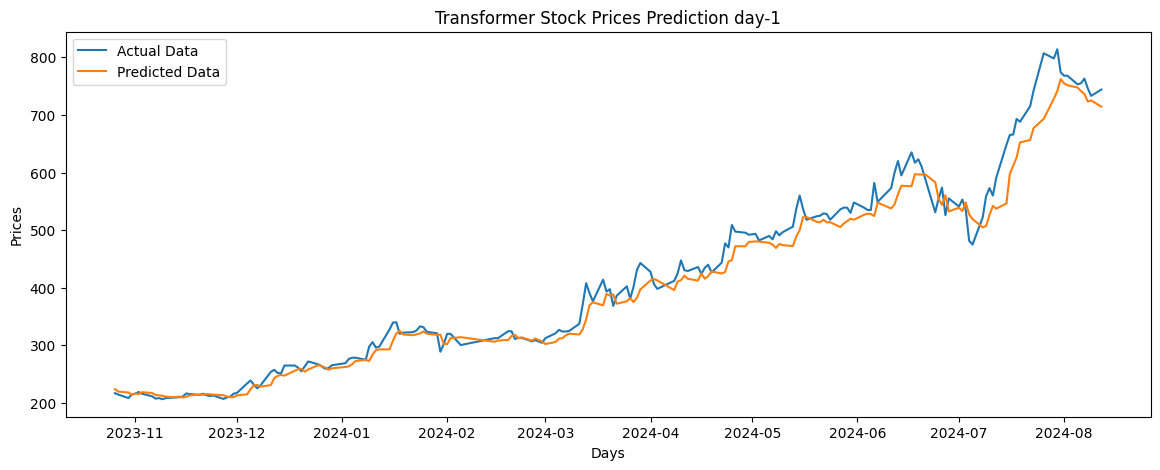

Day 1 MSE: 736.9843079108177



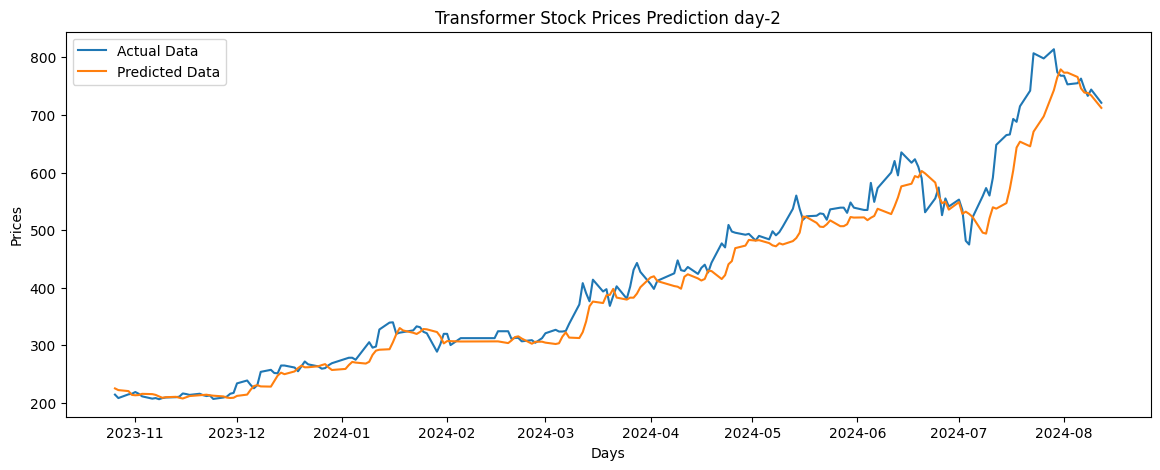

Day 2 MSE: 1148.0054263018187



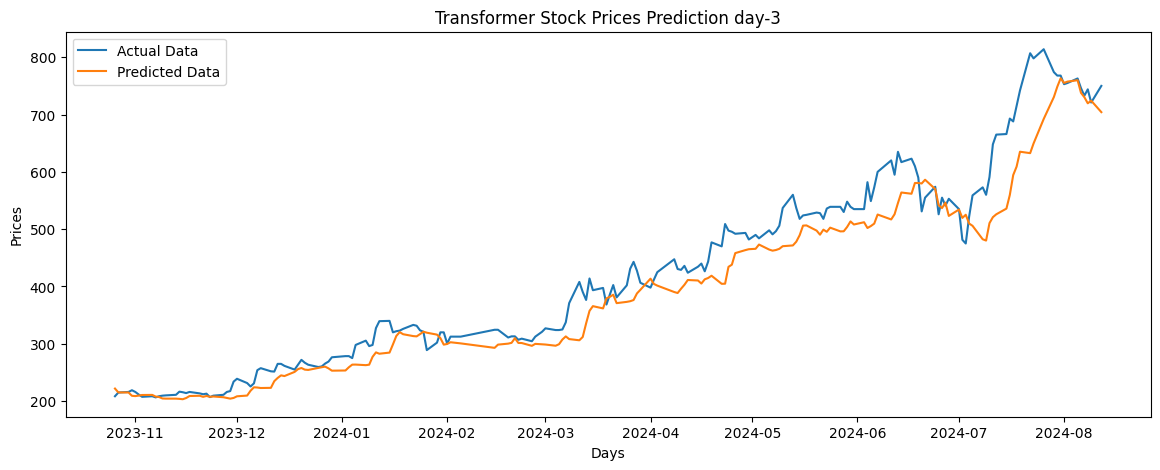

Day 3 MSE: 2072.2371644579525



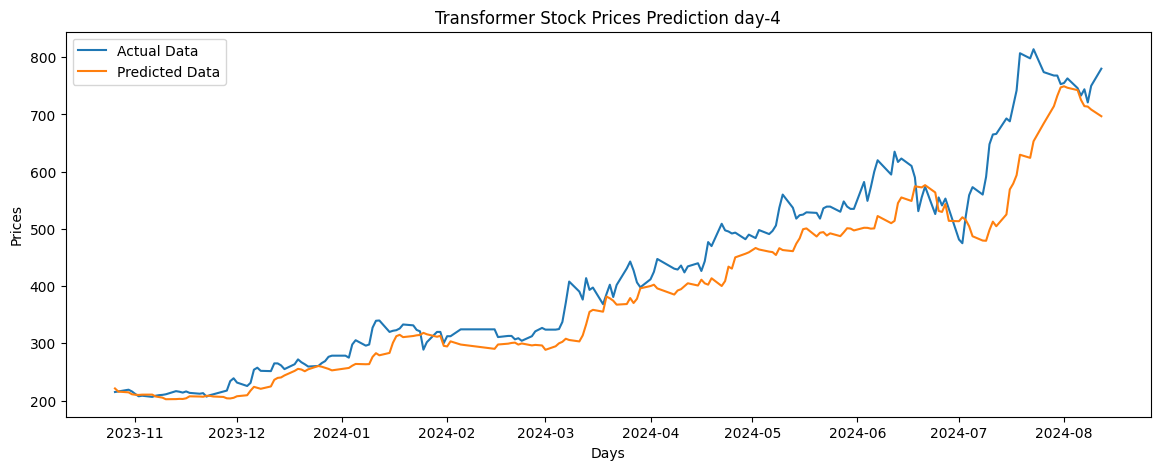

Day 4 MSE: 2910.788263367553



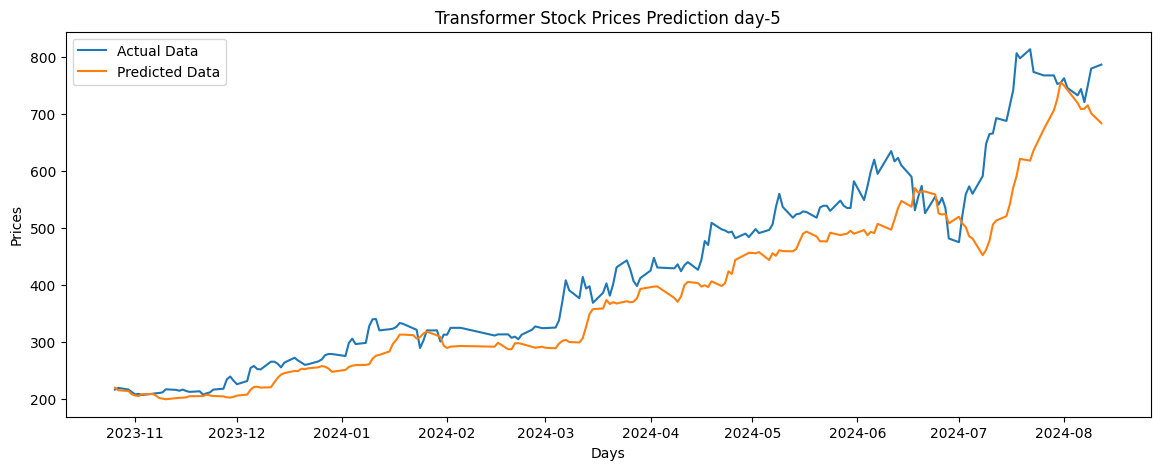

Day 5 MSE: 4098.028143757264



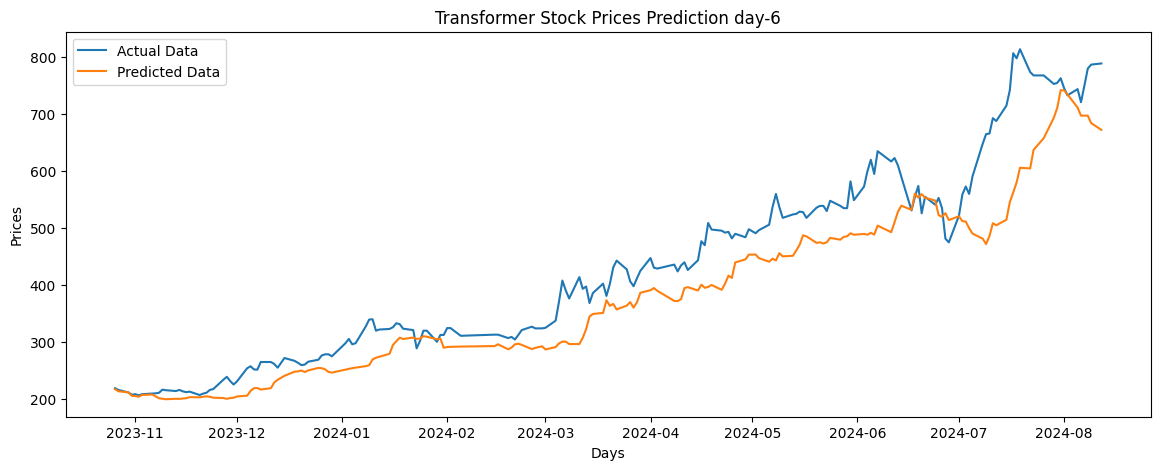

Day 6 MSE: 5005.811015674797



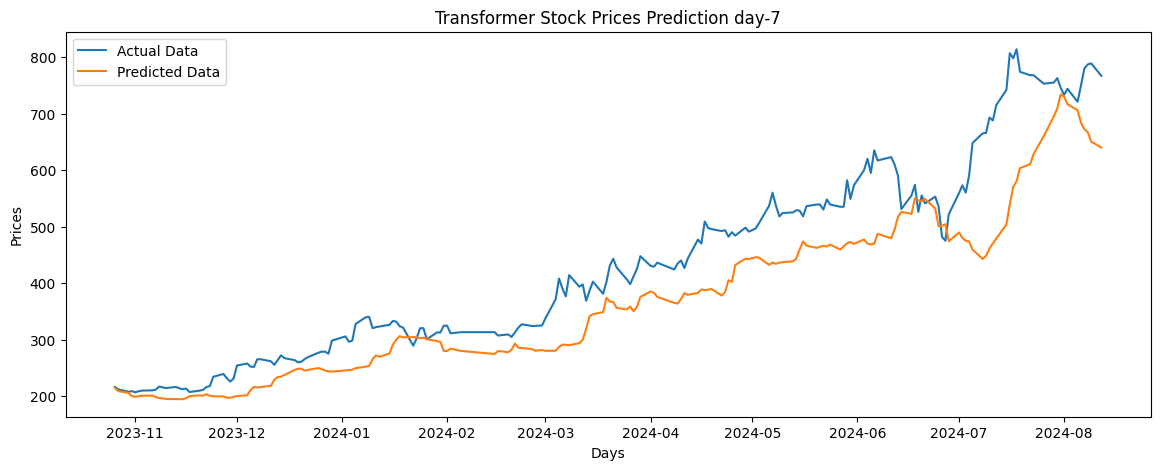

Day 7 MSE: 7050.512249042979



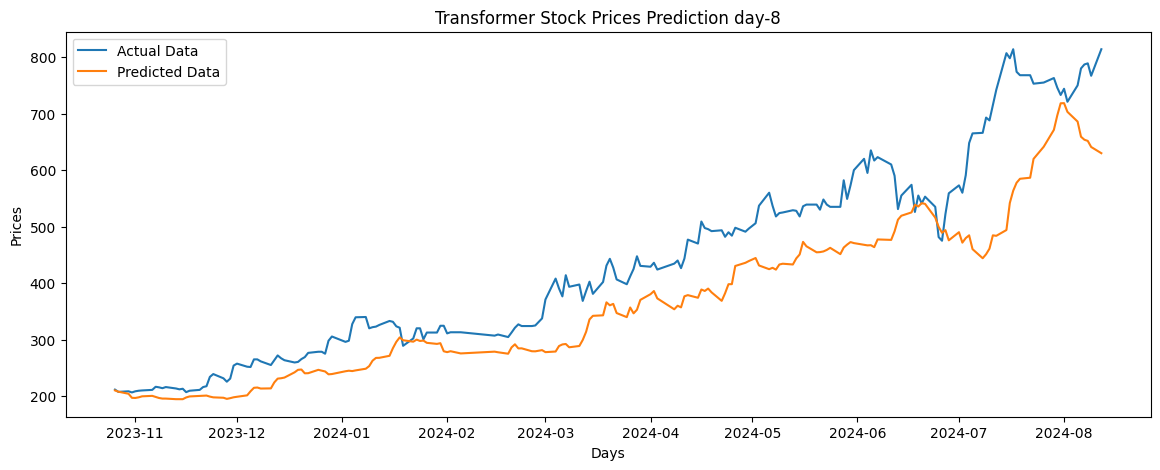

Day 8 MSE: 8366.486068426098



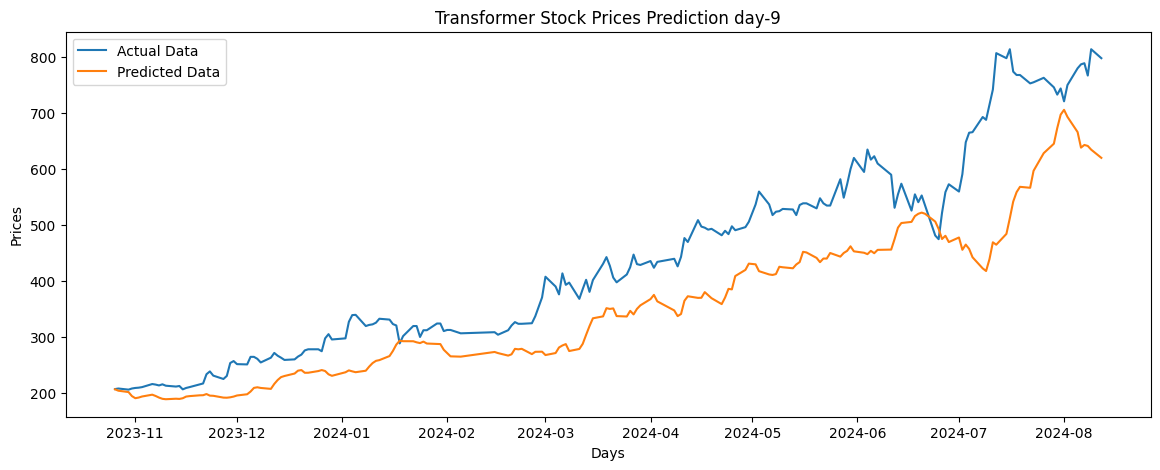

Day 9 MSE: 11166.63991919698



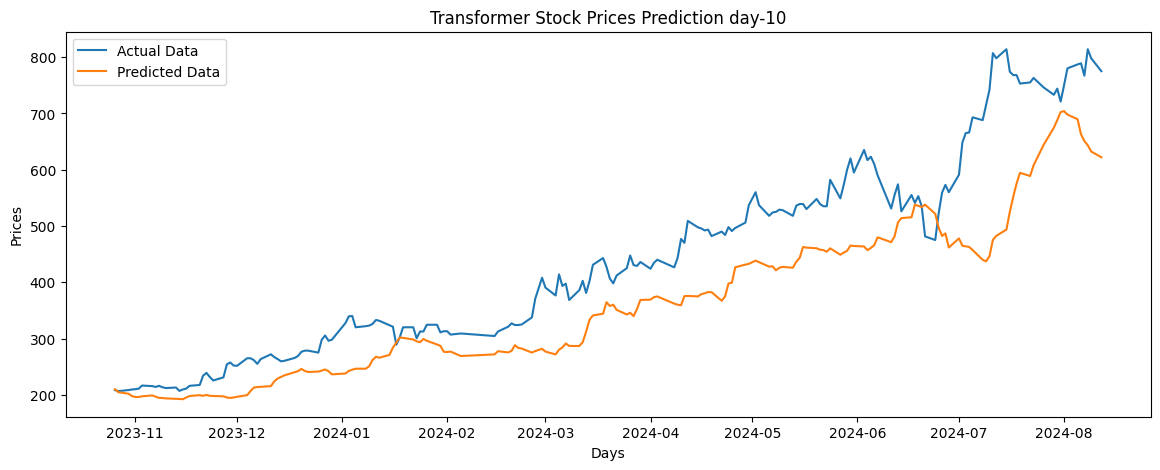

Day 10 MSE: 10485.26482323298



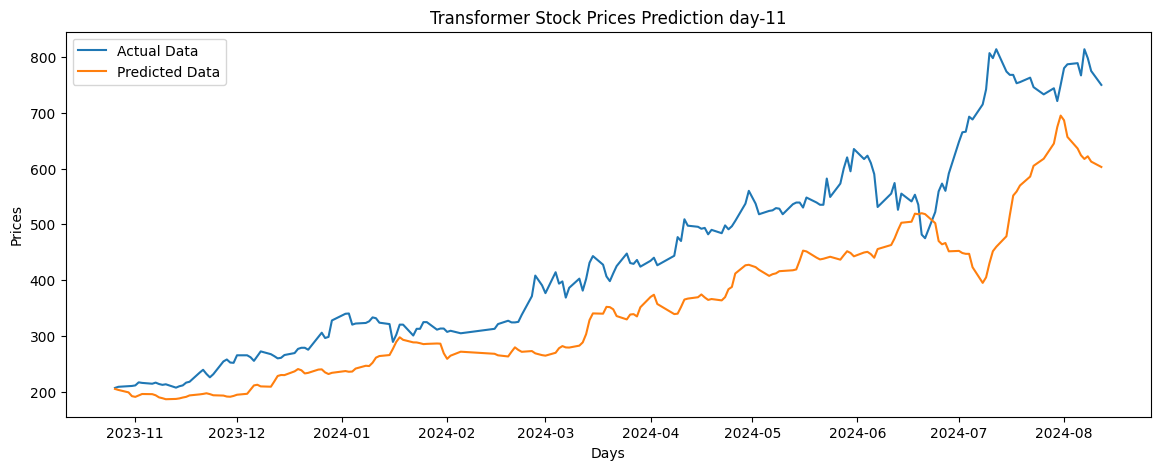

Day 11 MSE: 13637.06328919694



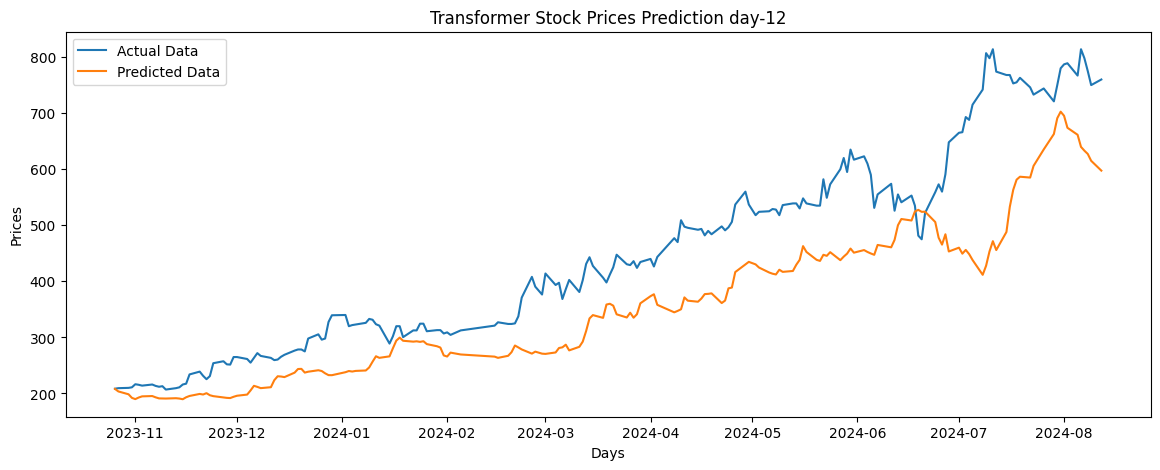

Day 12 MSE: 13221.44535192993



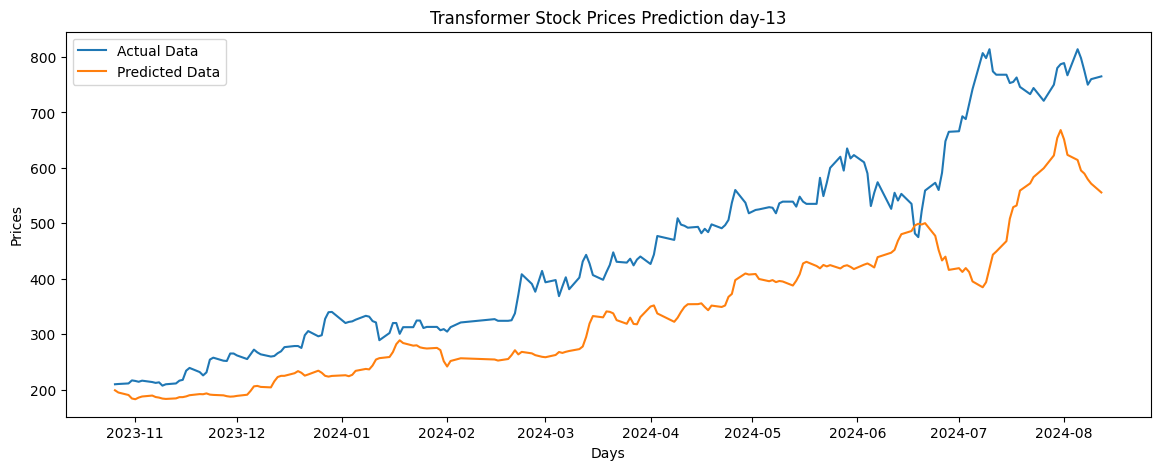

Day 13 MSE: 18758.392326933492



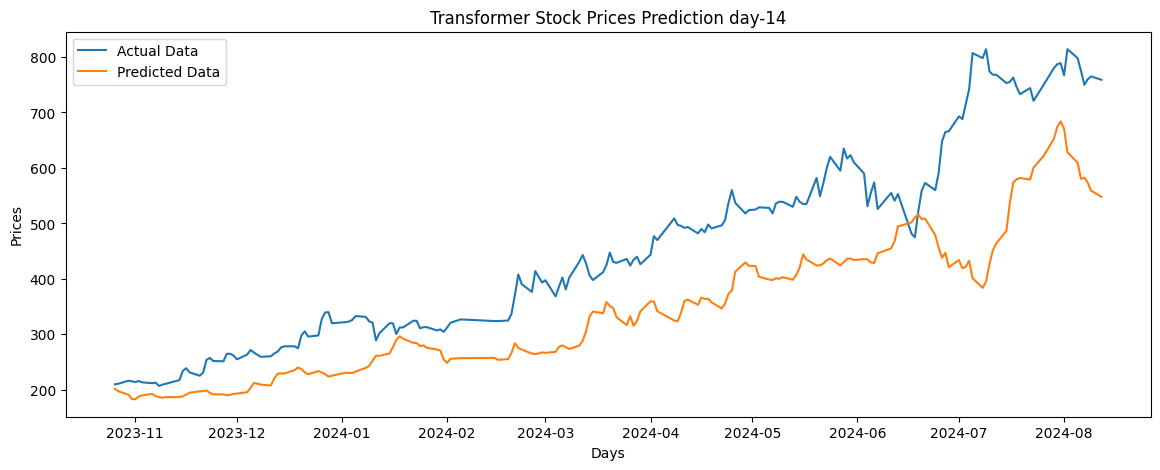

Day 14 MSE: 17809.67331047026



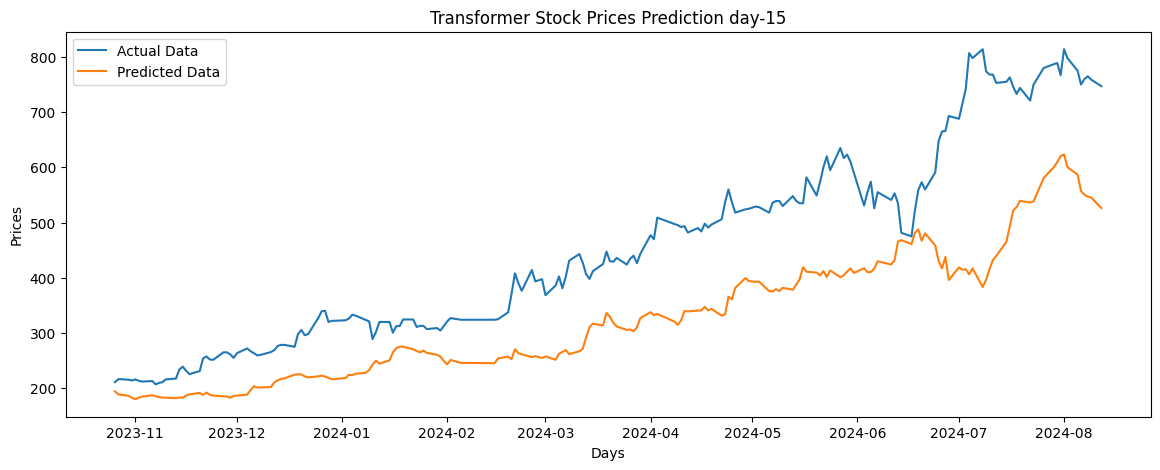

Day 15 MSE: 22972.799689185762



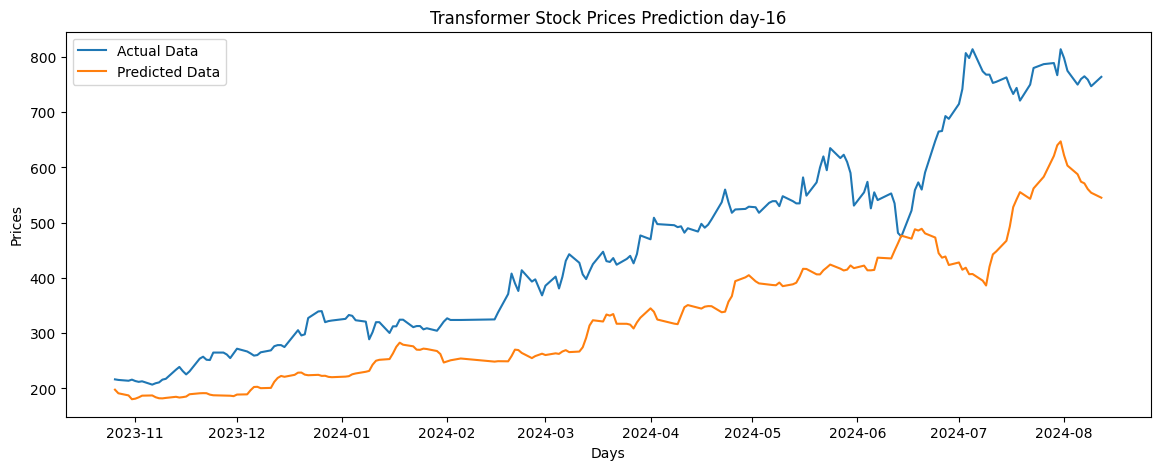

Day 16 MSE: 22335.880599574797



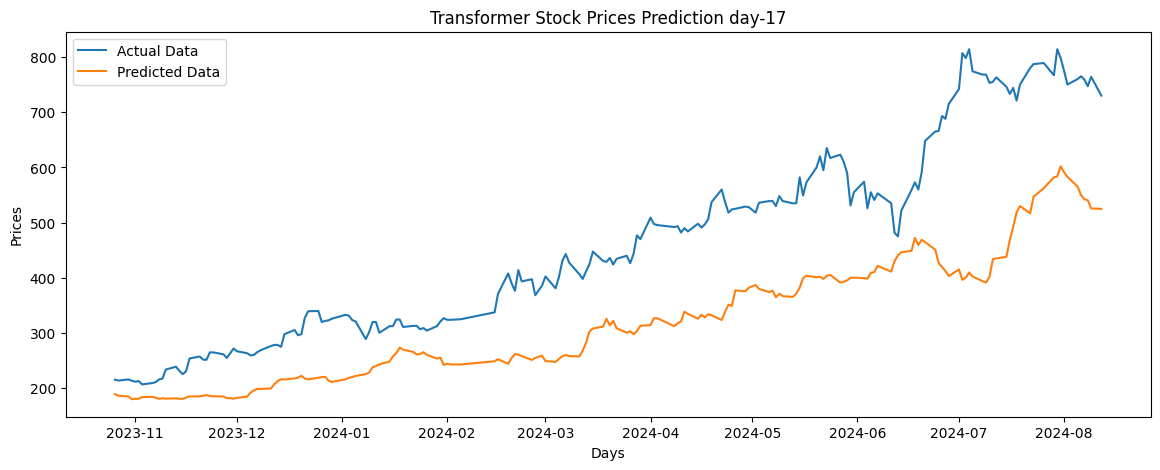

Day 17 MSE: 26803.554776465066



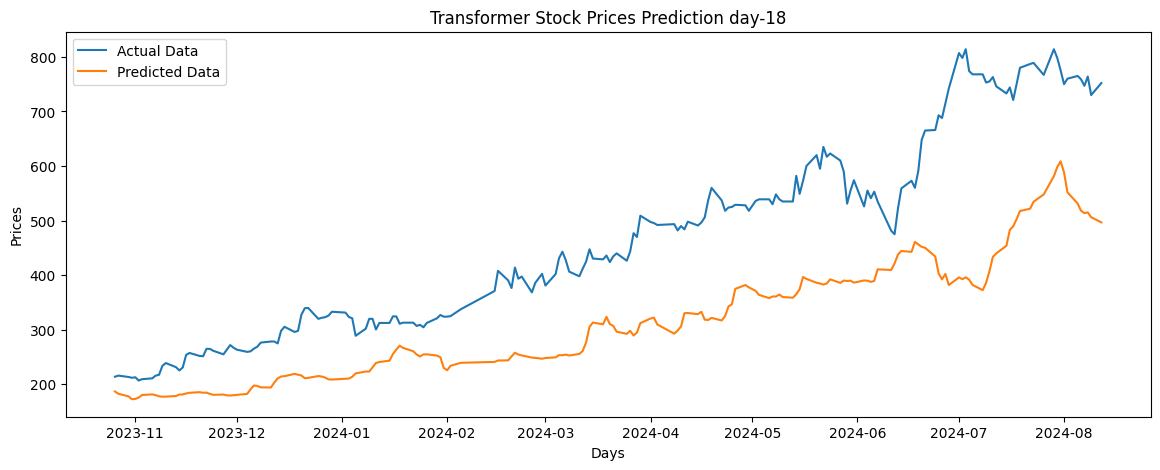

Day 18 MSE: 30092.446012891804



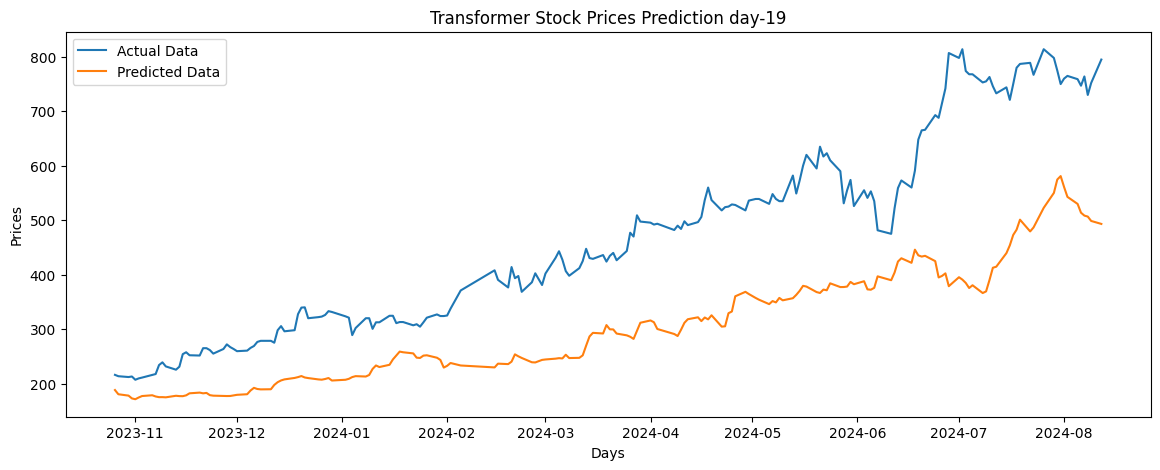

Day 19 MSE: 34325.43987473166



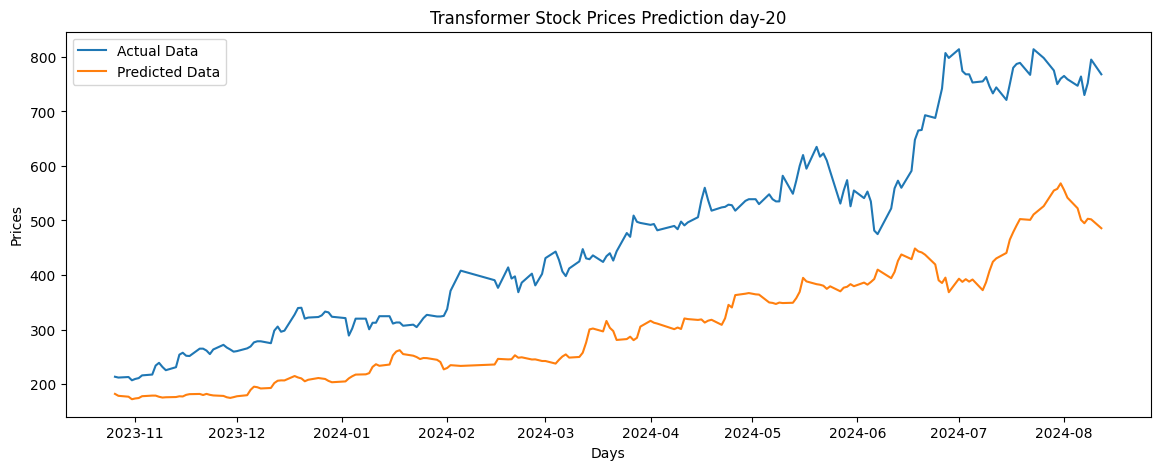

Day 20 MSE: 34567.239033027414



In [44]:
from sklearn.metrics import mean_squared_error  # 均方誤差

for i in range(n_outputs):
    plt.figure(figsize=(14, 5))
    test_true_df = pd.DataFrame(
        test_true[:, i], columns=['Actual'], index=test_data.index[:len(test_true)])
    test_predict_df = pd.DataFrame(
        y_pred[:, i], columns=['Predicted'], index=test_data.index[:len(y_pred)])
    plt.plot(test_true_df, label='Actual Data')  # 畫出實際數據
    plt.plot(test_predict_df, label='Predicted Data')  # 畫出預測數據
    plt.title(f'Transformer Stock Prices Prediction day-{i + 1}')
    plt.xlabel('Days')
    plt.ylabel('Prices')
    plt.legend()
    plt.show()
    mse = mean_squared_error(test_true[:, i], y_pred[:, i])
    print(f'Day {i + 1} MSE:', mse)
    print()